In [24]:
import time
import json  # for checkpointing
import csv

from pathlib import Path

import numpy as np
import scipy.sparse
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

import pandas as pd

import datetime

import os
from dotenv import load_dotenv, find_dotenv

from timeit import default_timer as timer

load_dotenv(find_dotenv('config.env'))

torch.cuda.current_device()
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)
torch.cuda.is_available()

True

In [25]:
!nvidia-smi

Wed Mar 24 16:46:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:E0:00.0 Off |                    0 |
| N/A   27C    P0    50W / 350W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
ticks_tiles_newlined = [
    "1\nman",
    "2\nman",
    "3\nman",
    "4\nman",
    "5\nman",
    "6\nman",
    "7\nman",
    "8\nman",
    "9\nman",
    "1\npin",
    "2\npin",
    "3\npin",
    "4\npin",
    "5\npin",
    "6\npin",
    "7\npin",
    "8\npin",
    "9\npin",
    "1\nsou",
    "2\nsou",
    "3\nsou",
    "4\nsou",
    "5\nsou",
    "6\nsou",
    "7\nsou",
    "8\nsou",
    "9\nsou",
    "\nEast",
    "\nSouth",
    "\nWest",
    "\nNorth",
    "\nHaku",
    "\nHatsu",
    "\nChun"
]

ticks_tiles_oneline = [
    "1 man",
    "2 man",
    "3 man",
    "4 man",
    "5 man",
    "6 man",
    "7 man",
    "8 man",
    "9 man",
    "1 pin",
    "2 pin",
    "3 pin",
    "4 pin",
    "5 pin",
    "6 pin",
    "7 pin",
    "8 pin",
    "9 pin",
    "1 sou",
    "2 sou",
    "3 sou",
    "4 sou",
    "5 sou",
    "6 sou",
    "7 sou",
    "8 sou",
    "9 sou",
    "East",
    "South",
    "West",
    "North",
    "Haku",
    "Hatsu",
    "Chun"
]

In [27]:
##############################################
# PARAMETERS
##############################################
torch.manual_seed(0)
np.random.seed(0)

DEVICE = torch.device("cuda")
EPOCHS = 20
DATASET_CONFIG = 'balanced_test'
SHUFFLE_DATASET = True

if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0) / 1024 ** 3, 1), 'GB')

Tesla V100-SXM3-32GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [28]:
##############################################
# CLASSES
##############################################


class DiscardDataset(torch.utils.data.Dataset):

    # TODO: Add REVERSE for YEARS?
    def __init__(self, data_path, years: list, n_rows: int = None,  phase: int = None, balance_data: bool = False, reverse_years: bool = False):

        # If n_rows = None -> get all

        if n_rows:
            print(f"Loading Dataset with {n_rows} rows", end=' ')
        else:
            print(f"Loading Dataset with all rows", end=' ')
            
        if balance_data:
            print('<Balanced>', end=' ')

        if phase in [0, 1, 2]:
            print(f"(Phase {phase})", end=' ')
        else:
            print(f"(All Phases)", end=' ')
            
        print(years, end=' ')
        if reverse_years:
            print('<REVERSED>')
            years = list(reversed(years))
            
        if balance_data:

            if not n_rows:
                raise BaseException("`n_rows` must be defined if `balance_data` is True!")

            class_bins = np.zeros(34)
            temp_matrices = []

            baseline_bin_size = n_rows // 34  # The expected size of the smallest bin

            paths_load_bar = tqdm(total=baseline_bin_size * 34, unit='rows', position=0)
            finished = False
            for year in years:

                paths = (Path(data_path) / str(year)).iterdir()

                for idx, path in enumerate(paths):

                    arr = scipy.sparse.load_npz(path).toarray()
                    class_bins += np.bincount(arr[:, -1], minlength=34)

                    temp_matrices.append(arr)

                    paths_load_bar.set_postfix(year_folder=year, files_loaded=(idx + 1))  # Update Bar

                    smallest_class_bin = int(np.amin(class_bins))
                    if smallest_class_bin >= baseline_bin_size:
                        finished = True
                        break

                    paths_load_bar.n = smallest_class_bin * 34
                    paths_load_bar.refresh()
                    # paths_load_bar.update(smallest_class_bin)
                    # prev_smallest_class_bin = smallest_class_bin

                if finished:
                    break
            
            if not finished:
                raise BaseException("Not enough data to build balanced dataset -- Add more annual datasets!")

            matrix = np.concatenate(temp_matrices, axis=0)
            matrix = matrix[np.argsort(matrix[:, -1])]  # Sort rows by last column (the y-value)
            net = np.array_split(matrix, np.where(np.diff(matrix[:, -1])!=0)[0]+1)
            for i in range(len(net)):
                net[i] = net[i][:baseline_bin_size]

            arr = np.concatenate(net, axis=0)

        else:
            
            loaded_rows = 0
            temp_matrices = []
            paths_load_bar = tqdm(total=n_rows, unit='rows', position=0)
            for year in years:
                
                paths = (Path(data_path) / str(year)).iterdir()

                for idx, path in enumerate(paths):

                    arr = scipy.sparse.load_npz(path)

                    if phase is not None and phase in [0, 1, 2]:
                        phased_matrices = self.generate_phase_column(arr.toarray())
                        arr = phased_matrices[phase]

                    loaded_rows += arr.shape[0]

                    temp_matrices.append(arr)

                    paths_load_bar.set_postfix(files_loaded=(idx + 1))  # Update Bar

                    if n_rows and n_rows <= loaded_rows:
                        break

                    paths_load_bar.update(arr.shape[0])

                if 1 < len(temp_matrices):
                    arr = scipy.sparse.vstack(temp_matrices, format='csr', dtype=np.int8)
                else:
                    arr = temp_matrices[0]

                # Due to the option to filter phases, the array is sometimes not of type np.ndarray
                if type(arr) is not np.ndarray:
                    arr = arr.toarray()

                if n_rows:
                    arr = arr[:n_rows]

        # Finalize tqdm bar
        paths_load_bar.n = arr.shape[0]
        paths_load_bar.last_print_n = arr.shape[0]
        paths_load_bar.refresh()
        paths_load_bar.close()

        self.x_data = torch.FloatTensor(arr[:, :-1])  # Must be Float it seems
        self.y_data = torch.LongTensor(arr[:, -1])  # Must be Long it seems

    @staticmethod
    def generate_phase_column(array: np.array) -> np.array:
        # Begin with merging all pools together

        merged_discards = array[:, 238:]  # Discards
        merged_discards = np.sum(merged_discards, axis=1)

        phases = np.zeros([array.shape[0]])  # Early Game
        phases[(24 < merged_discards) & (merged_discards <= 48)] = 1  # Mid Game
        phases[(48 < merged_discards)] = 2  # End Game

        return array[(phases == 0)], array[(phases == 1)], array[(phases == 2)]

    def __len__(self):
        return self.x_data.shape[0]

    def __getitem__(self, idx):
        return {
            'X': self.x_data[idx],
            'y': self.y_data[idx]
        }

# DATASET
```
# CONCATENATED DATASET EXAMPLE
train_dataset = torch.utils.data.ConcatDataset([
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=0),
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=1),
    DiscardDataset('data/2019_discard_dataset/', 1_000_000, phase=2)
])

test_dataset = torch.utils.data.ConcatDataset([
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=0, reverse=True),
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=1, reverse=True),
    DiscardDataset('data/2019_discard_dataset/', 1_000, phase=2, reverse=True)
])
```

In [29]:
# Load from configurations
ds_configs = pd.read_csv('Dataset Configurations.csv', index_col='dataset_name')
selected_config = ds_configs.loc[DATASET_CONFIG]
selected_config

train_size          34000
validation_size      1000
test_size            1000
batch                  32
phases                 -1
years_training       1100
years_validation       10
years_testing           1
balanced_data         110
Name: balanced_test, dtype: int64

In [30]:
def get_years(code: str) -> list:
    code = int(f"0b{code:0>11}", 2)
    found_years = []
    for i in range(11):
        if (code >> i) & 1:
            found_years.append(2019 - i)
    found_years.reverse()
    return found_years

In [31]:
def get_balanced_data_options(code: str):
    results = [False, False, False]
    code = int(f"0b{code:0>11}", 2)
    results[0] = code & 0b100 != 0
    results[1] = code & 0b010 != 0
    results[2] = code & 0b001 != 0
    return results

In [32]:
print("\nLOADING DATASETS:\n")

# Setup of Parameters
DATASET_PATH = Path(os.environ.get('DISCARD_DATASET'))  # Get path
BATCH_SIZE = int(selected_config['batch'])  # We must cast it or else it will crash
BALANCED_TRAINING, BALANCED_VALIDATION, BALANCED_TEST = get_balanced_data_options(selected_config['balanced_data'])  # 3 boolean values

# Training Dataset
train_dataset = DiscardDataset(DATASET_PATH,
                               n_rows=selected_config['train_size'],
                               years=get_years(selected_config['years_training']),
                               phase=selected_config['phases'],
                               balance_data=BALANCED_TRAINING
                              )

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Validation Dataset
validation_dataset = DiscardDataset(DATASET_PATH,
                                    n_rows=selected_config['validation_size'],
                                    years=get_years(selected_config['years_validation']),
                                    phase=selected_config['phases'],
                                    balance_data=BALANCED_VALIDATION
                                   )

validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

# Test Dataset
test_dataset = DiscardDataset(DATASET_PATH, 
                              n_rows=selected_config['test_size'], 
                              years=get_years(selected_config['years_testing']),
                              phase=selected_config['phases'],
                              balance_data=BALANCED_TEST
                             )

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=SHUFFLE_DATASET)


LOADING DATASETS:

Loading Dataset with 34000 rows <Balanced> (All Phases) [2016, 2017]


  0%|          | 0/34000 [00:00<?, ?rows/s]

Loading Dataset with 1000 rows <Balanced> (All Phases) [2018]


  0%|          | 0/986 [00:00<?, ?rows/s]

Loading Dataset with 1000 rows (All Phases) [2019]


  0%|          | 0/1000 [00:00<?, ?rows/s]

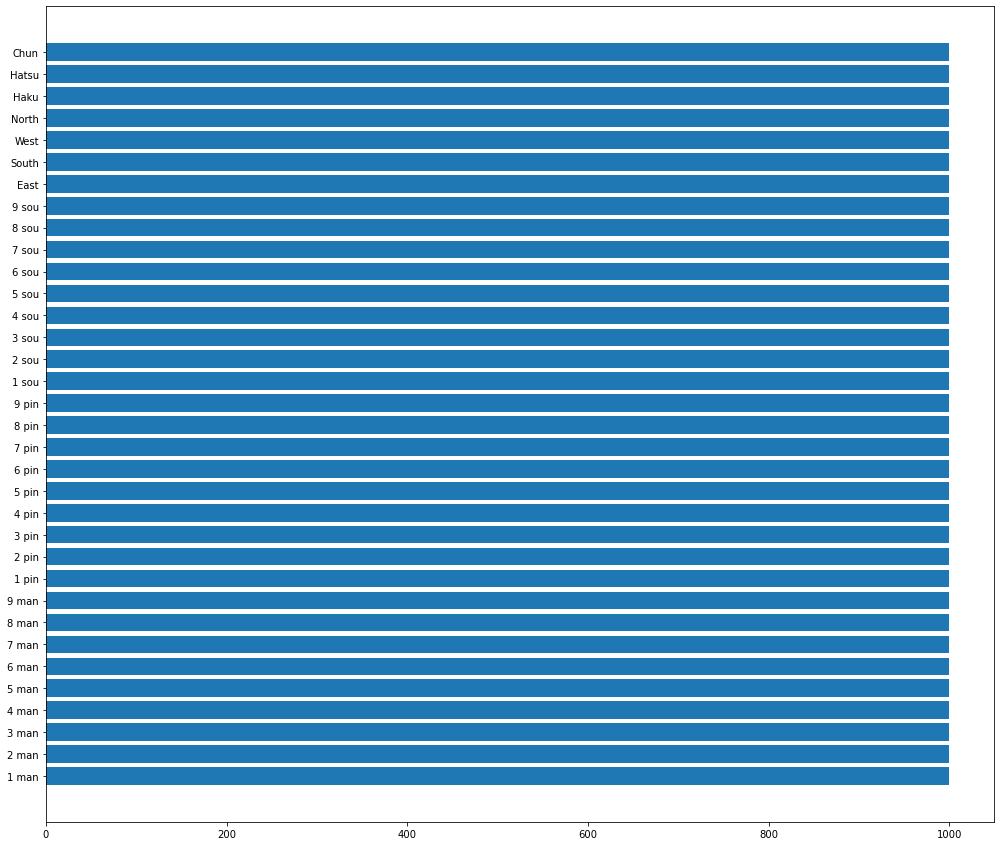

In [33]:
# TRAINING SET DISTRIBUTION
keys, counts = np.unique(train_dataset.y_data, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

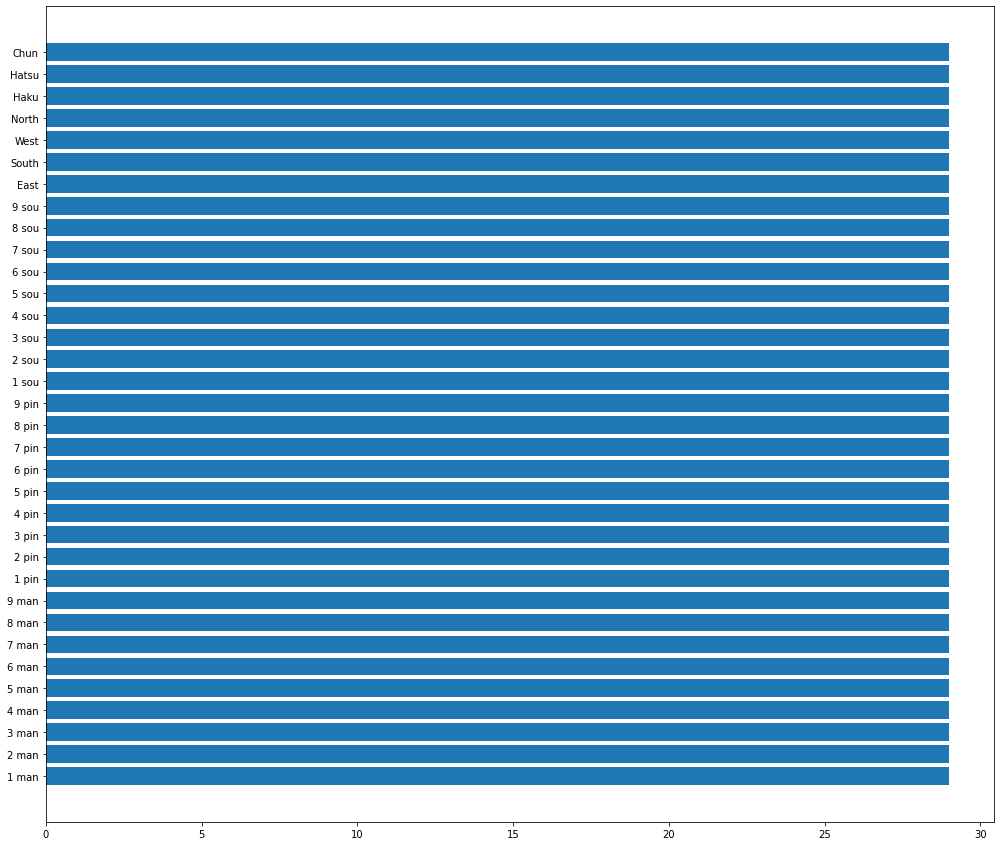

In [34]:
# VALIDATION SET DISTRIBUTION
keys, counts = np.unique(validation_dataset.y_data, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

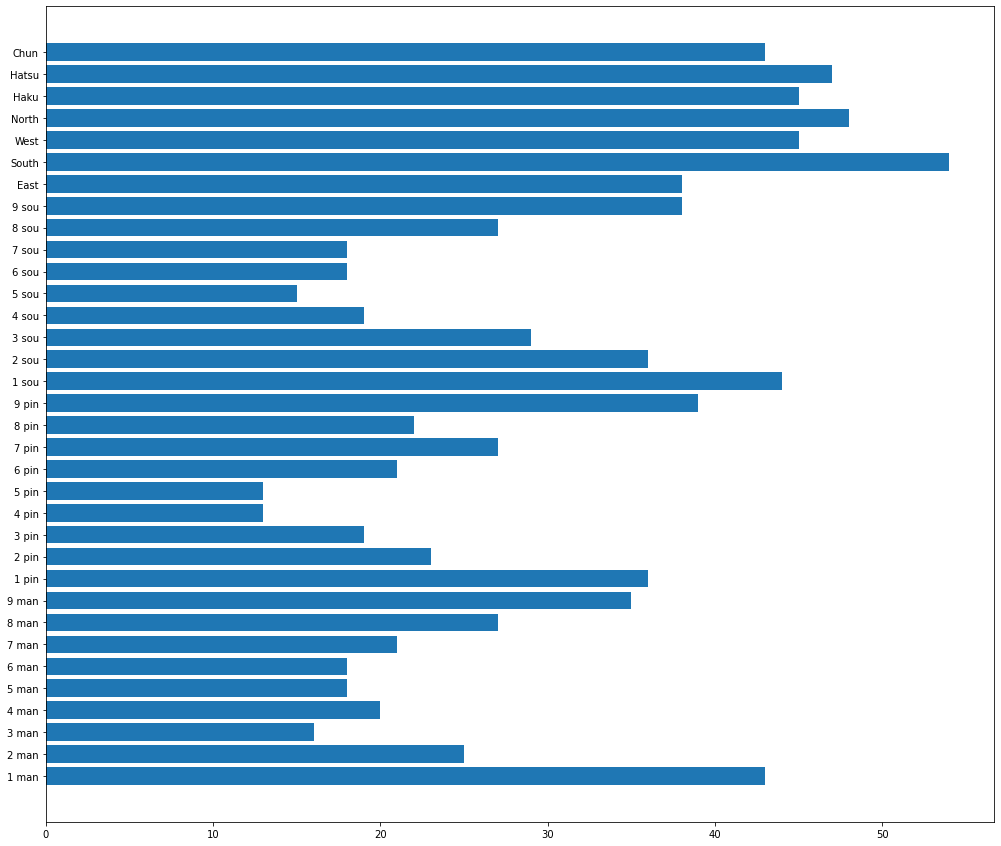

In [35]:
# VALIDATION SET DISTRIBUTION
keys, counts = np.unique(test_dataset.y_data, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

# Model Creation

## Basic Network

In [ ]:
class Net(torch.nn.Module):
    """ Simple Feed-Forward Net """

    def __init__(self):
        super(Net, self).__init__()
        
        self.name = "BasicDenseNetwork_testing"
        
        self.fc1 = torch.nn.Linear(11 * 34, 1028)
        self.fc2 = torch.nn.Linear(1028, 512)
        self.fc3 = torch.nn.Linear(512, 256)
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, 34)
        
        self.relu_1 = torch.nn.LeakyReLU()
        self.relu_2 = torch.nn.LeakyReLU()
        self.relu_3 = torch.nn.LeakyReLU()
        self.relu_4 = torch.nn.LeakyReLU()

        
#         self.dropout_1 = torch.nn.Dropout()
#         self.dropout_2 = torch.nn.Dropout()
#         self.dropout_3 = torch.nn.Dropout()
#         self.dropout_4 = torch.nn.Dropout()


    def forward(self, x):
        x = self.fc1(x)
        x = self.relu_1(x)
        
        x = self.fc2(x)
        x = self.relu_2(x)
        
        x = self.fc3(x)
        x = self.relu_3(x)
        
        x = self.fc4(x)
        x = self.relu_4(x)
        
        x = self.fc5(x)

        return x

    
model = Net().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss().to(DEVICE)  # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loaded_epoch = 0

model

In [ ]:
LOAD_FOLDER = 'heavy_training_2021-03-21'  # Change this if you want to LOAD or NOT

# TO LOAD OR NOT LOAD
if LOAD_FOLDER:
    CHECKPOINT_PATH = Path('model_checkpoints') / LOAD_FOLDER
    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'

    last_epoch_file = sorted([c for c in CHECKPOINT_PATH.iterdir() if c.suffix == '.pt'])[-1]
    loaded_checkpoint = torch.load(last_epoch_file)
    print('Loaded Epoch', loaded_checkpoint['epoch'])

    model.load_state_dict(loaded_checkpoint['model_state'])
    optimizer.load_state_dict(loaded_checkpoint['optimizer_state'])
    loaded_epoch = loaded_checkpoint['epoch']

else:
    # Create Model Checkpoint Folder
    timestamp_string = time.strftime('%Y-%m-%d_%H-%M', time.localtime(time.time()))
    CHECKPOINT_PATH = Path('model_checkpoints') / f"{timestamp_string}_{model.name}"
    CHECKPOINT_PATH.mkdir()

    DESCRIPTION_PATH = CHECKPOINT_PATH / 'description.json'
    SUMMARY_PATH = CHECKPOINT_PATH / 'summary.csv'

    model_desc_json = {
        'model_name': model.name,
        'model_description': repr(model),
        'dataset_config': repr(selected_config)
    }

    with open(DESCRIPTION_PATH, 'w') as outfile:
        json.dump(model_desc_json, outfile)

    with open(SUMMARY_PATH, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "time_elapsed"])

# TRAINING & VALIDATION

In [ ]:
def seconds_to_hhmmss(s):
    seconds = s
    minutes = seconds // 60
    hours = minutes // 60
    return "%02d:%02d:%02d" % (hours, minutes % 60, seconds % 60)

In [ ]:
if loaded_epoch != 0:
    loaded_epoch += 1  # If epoch was loaded

# Progress Bars
mq = trange(EPOCHS, desc='EPOCH', unit='epoch', initial=loaded_epoch)
tq = trange(len(train_loader), desc=f'TRAINING', unit='batch')
vq = trange(len(validation_loader), desc=f'VALIDATION', unit='batch')

for epoch in range(loaded_epoch, EPOCHS):
    
    torch.manual_seed(epoch)
    start_timer = timer()  # Start timer

    
    ##############################################
    # TRAINING
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0

    model.train()
    for batch_idx, batch in enumerate(train_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        optimizer.zero_grad()

        outputs = model(X)  # Outputs float values for each class (do softmax on `outputs` to get distribution)
        
        # CUSTOM LOSS IN THE MAKING
#         hand_rows = X[:, 2*34:3*34]
#         sx = (hand_rows == 0)
#         sx = sx.double()
#         ss = sx * 1.1
#         ss += 1  # True => X, False => 1
#         augmented = outputs * ss
        loss = criterion(outputs, y)  # avg loss in batch -> No need for softmax if criterion = Cross Entropy Loss
        
        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size

        sum_epoch_loss += loss.item()
        sum_epoch_acc += batch_acc

        loss.backward()  # compute gradients
        optimizer.step()  # update weights
        
        tq.update(1)
    
    tq.refresh()
    time.sleep(0.1)
    avg_acc_train = sum_epoch_acc / len(train_loader)  # average accuracy
    avg_loss_train = sum_epoch_loss / len(train_loader)  # average loss

    ##############################################
    # VALIDATION
    ##############################################
    sum_epoch_loss = 0.0
    sum_epoch_acc = 0.0
    
    model.eval()
    for batch_idx, batch in enumerate(validation_loader):
        X = batch['X'].to(DEVICE)
        y = batch['y'].to(DEVICE)

        # optimizer.zero_grad()  # TODO: Needed?

        with torch.no_grad():  # Disables tracking of gradient
            outputs = model(X)
        loss = criterion(outputs, y)  # avg loss in batch

        predictions = torch.argmax(outputs, dim=1)
        num_correct_predictions = torch.sum(torch.eq(predictions, y)).item()
        batch_acc = num_correct_predictions / y.shape[0]  # y.shape[0] = batch_size

        sum_epoch_loss += loss.item()
        sum_epoch_acc += batch_acc
        
        vq.update(1)
    
    vq.refresh()
    time.sleep(0.1)
    avg_acc_val = sum_epoch_acc / len(validation_loader)  # average accuracy
    avg_loss_val = sum_epoch_loss / len(validation_loader)  # average loss
    
    ##############################################
    # EPOCH CLEAN-UP
    ##############################################
    elapsed_time = timer() - start_timer  # End Timer
    
    # Print Epoch Summary
    print('EPOCH {:>2}  |  TRAIN: loss={:.3f}, acc={:5.3f}  |  VALIDATION: loss={:.3f}, acc={:5.3f}  | TIME ELAPSED: {}'
          .format(epoch,
                  avg_loss_train, 
                  avg_acc_train,   
                  avg_loss_val, 
                  avg_acc_val,
                  seconds_to_hhmmss(elapsed_time),
                 ))
    
    # Save Epoch Summary to csv
    with open(SUMMARY_PATH, 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            epoch, 
            avg_loss_train,
            avg_acc_train,
            avg_loss_val,
            avg_acc_val,
            seconds_to_hhmmss(elapsed_time)
        ])

    # Checkpoint Creation
    training_checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
#         'train_acc': avg_acc_train,
#         'train_loss': avg_loss_train,
#         'val_acc': avg_acc_val,
#         'val_loss': avg_loss_val
    }
#     destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}-val_loss-{avg_loss_val:.3f}.pt')
    destination = CHECKPOINT_PATH / (f'epoch-{epoch:03}.pt')
    torch.save(training_checkpoint, destination)
    
    # Progress Bar Clean-up
    mq.update(1)
    tq.reset()
    vq.reset()

# Model TESTING

In [ ]:
def check_if_tile_in_hand(predicted_class, data) -> bool:
    """ Return True if predicted class is in hand. """
    return data[0][68:102][predicted_class] != 0

In [ ]:
print('\nTESTING')

torch.manual_seed(0)


n_correct = 0
n_wrong = 0

n_invalid_discards = 0
predictions = []
targets = []

model.eval()
for batch_idx, batch in enumerate(tqdm(test_loader, total=len(test_loader), desc=f'Testing', unit='batch')):

    X = batch['X'].to(DEVICE)
    y = batch['y'].to(DEVICE)
    
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(X)

#     outputs.append(output)  # 34-lengthed tensor

    big_idx = torch.argmax(output)
    if big_idx == y:
        n_correct += 1
    else:
        n_wrong += 1
        
    # Invalid Discards
    if not check_if_tile_in_hand(big_idx, X):
        n_invalid_discards += 1
        
    # Confusion Matrix
    predictions.append(big_idx.item())
    targets.append(y.item())

time.sleep(0.5)
acc = n_correct / (n_correct + n_wrong)
print("Testing Accuracy:", acc)

print("Number of Invalid Discards: {}".format(n_invalid_discards))
print("Invalid Discards Percentage: {}".format(n_invalid_discards / len(test_loader)))

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(targets, predictions, digits=3, zero_division=1))

# Resources


# Target Distribution

In [ ]:
keys, counts = np.unique([data['y'].item() for data in DiscardDataset(dataset_path / "2019", n_rows=None, phase=-1, reverse=False)], return_counts=True)
plt.figure(figsize=(17, 15))
plt.barh(keys, counts)
plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

In [ ]:
keys, counts = np.unique([data['y'].item() for data in test_dataset], return_counts=True)
plt.figure(figsize=(17, 15))
plt.barh(keys, counts)
plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

# Prediction Distribution

In [ ]:
keys, counts = np.unique(predictions, return_counts=True)
fig = plt.figure(figsize=(17, 15))
ax = plt.gca()
plt.barh(keys, counts)

plt.yticks(range(34), ticks_tiles_oneline)
plt.show()

In [ ]:
import sklearn
import pandas as pd
import seaborn as sns

In [ ]:
confusion_nparray = sklearn.metrics.confusion_matrix(targets, predictions, normalize='true')
df_cm = pd.DataFrame(confusion_nparray)
plt.figure(figsize=(14, 13))
sns.set(font_scale=1) # for label size
sns.heatmap(df_cm, annot=False, annot_kws={"size": 10}, square=True, xticklabels=ticks_tiles_oneline, yticklabels=ticks_tiles_oneline) # font size

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()

In [ ]:
summary = pd.read_csv(SUMMARY_PATH, index_col='epoch')
summary.info()

In [ ]:
# sns.set_style("ticks")
# sns.set_style("darkgrid", {"axes.facecolor": ".9"})
# sns.set_style("whitegrid")
sns.set_style("darkgrid")

In [ ]:
loss_train = summary['train_loss']
loss_val = summary['val_loss']
epochs = summary.index

figure = plt.figure(figsize=(8, 5))

plt.xticks(list(summary.index))

plt.plot(epochs, loss_train, label='Training loss')
plt.plot(epochs, loss_val, label='Validation loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# plt.figure(figsize=(8, 5))

# plt.xticks(list(summary.index))
# plt.yticks(np.arange(0, 1.1, 0.1))
# plt.ylim(0, 1)

# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')

# sns.lineplot(
#     data=summary[['train_acc', 'val_acc']], dashes=False
# )

# plt.show()

In [ ]:
loss_train = summary['train_acc']
loss_val = summary['val_acc']
epochs = list(summary.index)

figure = plt.figure(figsize=(8, 5))

plt.xticks(list(summary.index))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)

plt.plot(epochs, loss_train, label='Training accuracy')
plt.plot(epochs, loss_val, label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()